In [11]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models import GhostNet
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/ghostnet")
data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

13


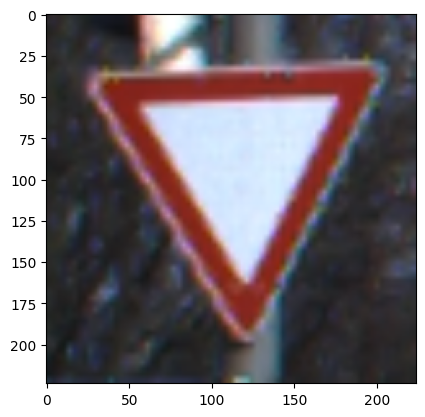

In [13]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [14]:
model = GhostNet(output_size=num_class).to(device)

In [15]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
GhostNet                                                          --
├─Sequential: 1-1                                                 --
│    └─Conv2dNormActivation: 2-1                                  --
│    │    └─Conv2d: 3-1                                           432
│    │    └─BatchNorm2d: 3-2                                      32
│    │    └─ReLU: 3-3                                             --
│    └─GhostLayer: 2-2                                            --
│    │    └─ResBlock: 3-4                                         768
│    └─GhostLayer: 2-3                                            --
│    │    └─ResBlock: 3-5                                         3,456
│    └─GhostLayer: 2-4                                            --
│    │    └─ResBlock: 3-6                                         4,224
│    └─GhostLayer: 2-5                                            --
│    │    └─ResBlock:

# training

In [16]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [17]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [18]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [19]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 416/416 [11:02<00:00,  1.59s/it]


epoch 1 : 0.00747656140111548


100%|██████████| 416/416 [01:23<00:00,  5.00it/s]


epoch 2 : 0.0018053916795766922


100%|██████████| 416/416 [01:27<00:00,  4.73it/s]


epoch 3 : 0.0005318437848787793


100%|██████████| 416/416 [01:25<00:00,  4.85it/s]


epoch 4 : 0.00026081344447867683


100%|██████████| 416/416 [01:27<00:00,  4.76it/s]


epoch 5 : 0.00017227656559271054


100%|██████████| 416/416 [01:25<00:00,  4.84it/s]


epoch 6 : 0.00015077277909697912


100%|██████████| 416/416 [01:34<00:00,  4.41it/s]


epoch 7 : 0.0001057804170607404


100%|██████████| 416/416 [01:36<00:00,  4.30it/s]


epoch 8 : 7.157144613118432e-05


100%|██████████| 416/416 [01:31<00:00,  4.54it/s]


epoch 9 : 9.042159746177101e-05


100%|██████████| 416/416 [01:24<00:00,  4.95it/s]

epoch 10 : 6.783351346392955e-05


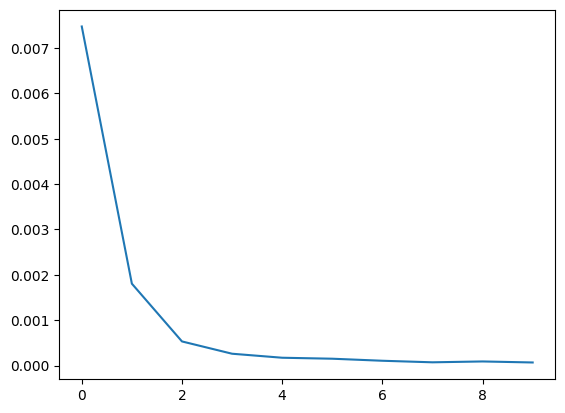

In [20]:
plt.plot(training_loss)

# inference

In [21]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [22]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [23]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [24]:
evaluator = ClassificationEvaluator(num_class, device)

In [25]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [02:18<00:00,  1.43it/s]

[[ 57   2   0 ...   0   0   0]
 [  0 702   4 ...   0   0   0]
 [  0   2 744 ...   0   0   0]
 ...
 [  0   0   1 ...  81   0   0]
 [  0   0   0 ...   0  37   8]
 [  0   0   0 ...   0   9  68]]


In [26]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.95
1         : 0.975
2         : 0.992
3         : 0.9577777777777777
4         : 0.9772727272727273
5         : 0.9634920634920635
6         : 0.8
7         : 0.9911111111111112
8         : 0.9466666666666667
9         : 1.0
10        : 0.9954545454545455
11        : 0.9928571428571429
12        : 0.9550724637681159
13        : 0.9930555555555556
14        : 0.9962962962962963
15        : 0.9571428571428572
16        : 1.0
17        : 0.9944444444444445
18        : 0.8153846153846154
19        : 0.7
20        : 0.6222222222222222
21        : 0.9666666666666667
22        : 0.8333333333333334
23        : 0.9333333333333333
24        : 0.9777777777777777
25        : 0.9604166666666667
26        : 0.9888888888888889
27        : 0.9666666666666667
28        : 0.9733333333333334
29        : 0.8777777777777778
30        : 0.74
31        : 0.9814814814814815
32        : 0.9833333333333333
33        : 0.7428571428571429
34        : 0.9416666666666667
35        : 0.953846153846153

In [27]:
per_class_acc.mean()

0.9017023200089427

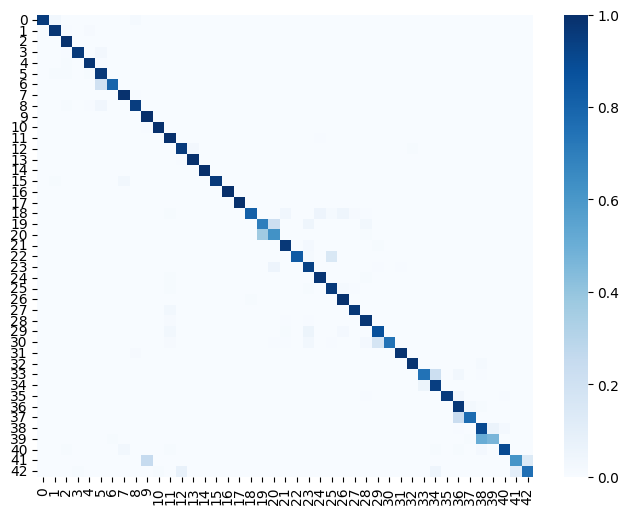

In [28]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [29]:
model_path = artifact_path / f'ghostnet.pth'

In [30]:
torch.save(model.state_dict(), model_path)

In [31]:
get_file_size(model_path)

'13.26MB'

In [32]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>